In [1]:
# Install required package for tokenization
!pip install spacy
!pip install bnlp-toolkit
!pip install datasets

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from datasets import load_dataset
from collections import Counter
import re
import math
import time
import matplotlib.pyplot as plt
import spacy
import bnlp
from bnlp import BasicTokenizer
import unicodedata
from tqdm import tqdm

In [3]:
# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# DATA PREPROCESSING

In [5]:
# Load dataset
dataset = load_dataset("opus100", "bn-en")

In [6]:
# Extract data
def extract_data(data, sample=None):
    if sample is not None:
        data = data.select(range(min(sample, len(data))))
    eng = [d["translation"]["en"] for d in data]
    ban = [d["translation"]["bn"] for d in data]
    return ban, eng

In [7]:
# Use smaller dataset for faster training
sample_size = 20000
train_ban, train_eng = extract_data(dataset["train"], sample_size)
val_ban, val_eng = extract_data(dataset["validation"], sample_size // 10)
test_ban, test_eng = extract_data(dataset["test"], sample_size // 10)

In [8]:
print(f"Train: {len(train_ban)} samples")
print(f"Validation: {len(val_ban)} samples")
print(f"Test: {len(test_ban)} samples")

Train: 20000 samples
Validation: 2000 samples
Test: 2000 samples


In [9]:
# Preprocessing classes
class ProcessBengaliCorpus:
    def __init__(self) -> None:
        self.data = None
        self.tokenizer = BasicTokenizer()

    def clean_data(self, data):
        # Remove English characters and numbers for pure Bengali
        self.data = list(map(lambda x: re.sub(r"[a-zA-Z0-9\()\_\-]", "", x), data))

        # Remove spaces around hasanta (্) (U+09CD)
        self.data = list(map(lambda x: re.sub(r"\s*\u09cd\s*", "\u09cd", x), self.data))

        # Remove standalone hasanta (্)
        self.data = list(map(lambda x: re.sub(r"\s+\u09cd", "", x), self.data))
        self.data = list(map(lambda x: re.sub(r"\u09cd\s+", "", x), self.data))

        # Remove extra whitespace
        self.data = list(map(lambda x: re.sub(r"\s+", " ", x), self.data))

        # Standardize punctuation
        self.data = [i.replace("ঃ", ":") for i in self.data]
        self.data = [i.replace("।", ".") for i in self.data]

        self.data = [i.strip() for i in self.data]

        # Normalize Unicode
        self.data = [unicodedata.normalize("NFC", i) for i in self.data]

        return self.data

    def tokenize_bengla(self, sen):
        # Tokenize Bengali text
        tokenized = self.tokenizer.tokenize(sen.strip())
        token = [str(t).strip() for t in tokenized if str(t).strip()]
        return token

In [10]:
class ProcessEnglishCorpus:
    def __init__(self) -> None:
        self.data = None
        self.eng_tokenizer = spacy.load(
            "en_core_web_sm", disable=["parser", "ner", "textcat"]
        )

    def clean_data(self, data):
        # Lowercase each word
        self.data = [i.lower() for i in data]

        # Keep basic punctuation
        self.data = list(map(lambda x: re.sub(r"[^\w\s\.\?\!,']", "", x), self.data))

        # Remove extra spaces
        self.data = list(map(lambda x: re.sub(r"\s+", " ", x), self.data))

        self.data = [i.strip() for i in self.data]

        return self.data

    def tokenize_english(self, text):
        # Tokenize English text
        tokenized = self.eng_tokenizer(text.strip())
        token = [t.text.lower() for t in tokenized]
        return token

In [11]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -------------------- ------------------- 6.6/12.8 MB 33.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 38.2 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [12]:
# Instantiate preprocessors
bn_proc = ProcessBengaliCorpus()
en_proc = ProcessEnglishCorpus()

In [13]:
# Clean all datasets
train_bn_clean = bn_proc.clean_data(train_ban)
train_en_clean = en_proc.clean_data(train_eng)
val_bn_clean = bn_proc.clean_data(val_ban)
val_en_clean = en_proc.clean_data(val_eng)
test_bn_clean = bn_proc.clean_data(test_ban)
test_en_clean = en_proc.clean_data(test_eng)

In [14]:
def tokenize_lists(str_list, lang="bn"):
    """Tokenize source and target"""
    if lang == "bn":
        return [bn_proc.tokenize_bengla(i) for i in str_list]
    else:
        return [en_proc.tokenize_english(i) for i in str_list]

In [15]:
# Tokenize datasets
train_bn_toks = tokenize_lists(train_bn_clean, lang="bn")
train_en_toks = tokenize_lists(train_en_clean, lang="en")
val_bn_toks = tokenize_lists(val_bn_clean, lang="bn")
val_en_toks = tokenize_lists(val_en_clean, lang="en")
test_bn_toks = tokenize_lists(test_bn_clean, lang="bn")
test_en_toks = tokenize_lists(test_en_clean, lang="en")

In [16]:
# Vocabulary class
class Vocab():
    def __init__(self):
        self.specials = ["<pad>", "<sos>", "<eos>", "<unk>"]

    def vocab_builder(self, data, max_size=30000, min_freq=2):
        counter = Counter()
        for sent in data:
            counter.update(sent)

        # Filter tokens by min_freq and exclude any special tokens that may appear in corpus
        words = [
            w for w, f in counter.items() if f > min_freq and w not in self.specials
        ]
        # Sort max to min
        words = sorted(words, key=lambda w: counter[w], reverse=True)
        
        # Reserve space for specials
        if max_size:
            words = words[: max_size - len(self.specials)]

        # mappings
        self.itos = list(self.specials) + words # main vocabulary 
        self.stoi = {w: i for i, w in enumerate(self.itos)} # word2key

        self.pad_idx = self.stoi["<pad>"]
        self.sos_idx = self.stoi["<sos>"]
        self.eos_idx = self.stoi["<eos>"]
        self.unk_idx = self.stoi["<unk>"]

    def get_itos(self):
        return self.itos

    def get_stoi(self):
        return self.stoi

    def encode(self, tokens, add_eos=True):
        #return indx of each token from main vocabulary
        ids = [self.stoi.get(t, self.unk_idx) for t in tokens]
        if add_eos:
            # add <eos> only for target
            ids.append(self.eos_idx)
        return ids

    def decode(self, ids):
        # get words based on ids
        out = []
        for i in ids:
            tok = self.itos[i] if 0 <= i < len(self.itos) else "<unk>"
            if tok in ("<eos>", "<pad>"):
                break
            if tok == "<sos>":
                continue
            out.append(tok)
        return out

In [17]:
# Build vocabularies from training data
src_vocab = Vocab()
src_vocab.vocab_builder(train_en_toks, max_size=50000, min_freq=2)
tgt_vocab = Vocab()
tgt_vocab.vocab_builder(train_bn_toks, max_size=50000, min_freq=2)

In [18]:
t = train_en_toks[0]
en = src_vocab.encode(t)
de = src_vocab.decode(en)
print(f"text= {t}")
print(f"encoded= {en}")
print(f"decoded= {de}")

text= ['yeah', '?']
encoded= [276, 17, 2]
decoded= ['yeah', '?']


In [19]:
t = train_bn_toks[0]
en = tgt_vocab.encode(t)
de = tgt_vocab.decode(en)
print(f"text= {t}")
print(f"encoded= {en}")
print(f"decoded= {de}")

text= ['হ্যাঁ', '?']
encoded= [301, 10, 2]
decoded= ['হ্যাঁ', '?']


In [20]:
# Dataset class with padding information
class BengaliEnglishDataset(Dataset):
    def __init__(self, src_token_lists, tgt_token_lists, src_vocab, tgt_vocab, max_len=50):
        self.src_token_lists = src_token_lists
        self.tgt_token_lists = tgt_token_lists
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_token_lists)

    def __getitem__(self, idx):
        src_tokens = self.src_token_lists[idx]
        tgt_tokens = self.tgt_token_lists[idx]

        # Encode with special tokens
        src_ids = [self.src_vocab.sos_idx] + self.src_vocab.encode(src_tokens, add_eos=False)
        tgt_ids = [self.tgt_vocab.sos_idx] + self.tgt_vocab.encode(tgt_tokens, add_eos=False)
        
        # Add EOS token
        src_ids = src_ids + [self.src_vocab.eos_idx]
        tgt_ids = tgt_ids + [self.tgt_vocab.eos_idx]

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

# Collate function with padding
def collate_fn(batch):
    src_list, tgt_list = [], []
    src_lengths, tgt_lengths = [], []
    
    for src, tgt in batch:
        src_list.append(src)
        tgt_list.append(tgt)
        src_lengths.append(len(src))
        tgt_lengths.append(len(tgt))
    
    # Sort by source length for pack_padded_sequence
    src_lengths = torch.tensor(src_lengths)
    src_sorted_len, src_sort_idx = src_lengths.sort(descending=True)
    src_list = [src_list[i] for i in src_sort_idx]
    
    # Sort target by the same order
    tgt_list = [tgt_list[i] for i in src_sort_idx]
    tgt_lengths = [tgt_lengths[i] for i in src_sort_idx]
    
    # Pad sequences
    src_padded = pad_sequence(src_list, batch_first=True, padding_value=src_vocab.pad_idx)
    tgt_padded = pad_sequence(tgt_list, batch_first=True, padding_value=tgt_vocab.pad_idx)
    
    return src_padded, tgt_padded, src_sorted_len, tgt_lengths, src_sort_idx

In [21]:
# Create datasets and dataloaders
max_len = 50
batch_size = 16

train_dataset = BengaliEnglishDataset(
    train_en_toks, train_bn_toks, src_vocab, tgt_vocab, max_len=max_len
)
val_dataset = BengaliEnglishDataset(
    val_en_toks, val_bn_toks, src_vocab, tgt_vocab, max_len=max_len
)
test_dataset = BengaliEnglishDataset(
    test_en_toks, test_bn_toks, src_vocab, tgt_vocab, max_len=max_len
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

# ATTENTION MECHANISMS

In [22]:
class GeneralAttention(nn.Module):
    """
    General Attention: e_i = s^T * h_i
    where s is decoder hidden state, h_i is encoder hidden state
    Assumes d1 = d2 (same dimensions)
    """

    def __init__(self, hidden_dim):
        super(GeneralAttention, self).__init__()
        self.hidden_dim = hidden_dim

    def forward(self, decoder_hidden, encoder_outputs):
        """
        Args:
            decoder_hidden: [batch_size, hidden_dim] - current decoder hidden state
            encoder_outputs: [batch_size, src_len, hidden_dim] - all encoder hidden states
        Returns:
            context: [batch_size, hidden_dim] - weighted context vector
            attention_weights: [batch_size, src_len] - attention distribution
        """
        # decoder_hidden: [batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        # Calculate attention scores: e_i = s^T * h_i
        # [batch_size, 1, hidden_dim] @ [batch_size, hidden_dim, src_len] = [batch_size, 1, src_len]
        attention_scores = torch.bmm(
            decoder_hidden.unsqueeze(1), encoder_outputs.transpose(1, 2)
        )
        attention_scores = attention_scores.squeeze(1)  # [batch_size, src_len]

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, src_len]

        # Calculate context vector: weighted sum of encoder outputs
        # [batch_size, 1, src_len] @ [batch_size, src_len, hidden_dim] = [batch_size, 1, hidden_dim]
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)  # [batch_size, hidden_dim]

        return context, attention_weights


class AdditiveAttention(nn.Module):
    """
    Additive Attention (Bahdanau Attention): e_i = v^T * tanh(W1*h_i + W2*s)
    """

    def __init__(self, hidden_dim, attention_dim=None):
        super(AdditiveAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim if attention_dim else hidden_dim

        # W1: projects encoder hidden states to attention_dim
        self.W1 = nn.Linear(hidden_dim, self.attention_dim, bias=False)
        # W2: projects decoder hidden state to attention_dim
        self.W2 = nn.Linear(hidden_dim, self.attention_dim, bias=False)
        # v: projects to scalar attention score
        self.v = nn.Linear(self.attention_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        Args:
            decoder_hidden: [batch_size, hidden_dim] - current decoder hidden state
            encoder_outputs: [batch_size, src_len, hidden_dim] - all encoder hidden states
        Returns:
            context: [batch_size, hidden_dim] - weighted context vector
            attention_weights: [batch_size, src_len] - attention distribution
        """
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Expand decoder hidden state to match encoder outputs shape
        # [batch_size, hidden_dim] -> [batch_size, src_len, hidden_dim]
        decoder_hidden_expanded = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        # Calculate attention scores: e_i = v^T * tanh(W1*h_i + W2*s)
        # [batch_size, src_len, attention_dim]
        encoder_proj = self.W1(encoder_outputs)
        decoder_proj = self.W2(decoder_hidden_expanded)

        # tanh(W1*h_i + W2*s)
        tanh_output = torch.tanh(
            encoder_proj + decoder_proj
        )  # [batch_size, src_len, attention_dim]

        # v^T * tanh(...)
        attention_scores = self.v(tanh_output).squeeze(2)  # [batch_size, src_len]

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, src_len]

        # Calculate context vector: weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)  # [batch_size, hidden_dim]

        return context, attention_weights

# ENCODER & DECODER

In [23]:
# ENCODER
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        n_layers=2,
        dropout=0.5,
        bidirectional=True,
    ):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=src_vocab.pad_idx
        )
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lengths):
        """
        Args:
            src: [batch_size, src_len] - source sequences
            src_lengths: [batch_size] - lengths of source sequences
        Returns:
            outputs: [batch_size, src_len, hidden_dim * num_directions] - RNN outputs
            hidden: [n_layers * num_directions, batch_size, hidden_dim] - final hidden state
        """
        embedded = self.dropout(
            self.embedding(src)
        )  # [batch_size, src_len, embedding_dim]

        # Pack padded sequences
        packed_embedded = pack_padded_sequence(
            embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=True
        )

        packed_outputs, hidden = self.rnn(packed_embedded)

        # Unpack sequences
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

        # outputs: [batch_size, src_len, hidden_dim * num_directions]
        # hidden: [n_layers * num_directions, batch_size, hidden_dim]

        # Sum bidirectional outputs if bidirectional
        if self.bidirectional:
            outputs = (
                outputs[:, :, : self.hidden_dim] + outputs[:, :, self.hidden_dim :]
            )

        return outputs, hidden


# DECODER


class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        n_layers=2,
        dropout=0.5,
        attention_type="general",
    ):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention_type = attention_type

        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=tgt_vocab.pad_idx
        )

        # Attention mechanism
        if attention_type == "general":
            self.attention = GeneralAttention(hidden_dim)
        elif attention_type == "additive":
            self.attention = AdditiveAttention(hidden_dim)
        else:
            raise ValueError(f"Unknown attention type: {attention_type}")

        # Input to RNN: [embedded_input, context]
        self.rnn = nn.GRU(
            embedding_dim + hidden_dim,
            hidden_dim,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
        )

        # Output layer
        self.fc_out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        """
        Args:
            input: [batch_size] - current input token
            hidden: [n_layers, batch_size, hidden_dim] - previous hidden state
            encoder_outputs: [batch_size, src_len, hidden_dim] - encoder outputs
        Returns:
            output: [batch_size, vocab_size] - predicted token distribution
            hidden: [n_layers, batch_size, hidden_dim] - new hidden state
            attention_weights: [batch_size, src_len] - attention weights
        """
        # Add sequence dimension
        input = input.unsqueeze(1)  # [batch_size, 1]

        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, embedding_dim]

        # Use last layer hidden state for attention
        last_hidden = hidden[-1]  # [batch_size, hidden_dim]

        # Calculate attention
        context, attention_weights = self.attention(last_hidden, encoder_outputs)

        # Expand context for concatenation
        context = context.unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Concatenate embedded input with context
        rnn_input = torch.cat(
            (embedded, context), dim=2
        )  # [batch_size, 1, embedding_dim + hidden_dim]

        # RNN step
        output, hidden = self.rnn(rnn_input, hidden)

        # Remove sequence dimension
        output = output.squeeze(1)  # [batch_size, hidden_dim]
        context = context.squeeze(1)  # [batch_size, hidden_dim]

        # Predict next token
        output = torch.cat((output, context), dim=1)  # [batch_size, hidden_dim * 2]
        output = self.fc_out(output)  # [batch_size, vocab_size]

        return output, hidden, attention_weights

# SEQ2SEQ MODEL

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        """
        Args:
            src: [batch_size, src_len] - source sequences
            src_lengths: [batch_size] - source lengths
            trg: [batch_size, trg_len] - target sequences
            teacher_forcing_ratio: probability of using teacher forcing
        Returns:
            outputs: [batch_size, trg_len, vocab_size] - predicted distributions
            attention_weights: [batch_size, trg_len, src_len] - attention weights for visualization
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Tensor to store attention weights
        attention_weights = torch.zeros(batch_size, trg_len, src.shape[1]).to(
            self.device
        )

        # Encode source sequence
        encoder_outputs, hidden = self.encoder(src, src_lengths)

        # First input to decoder is <sos> token
        input = trg[:, 0]

        for t in range(1, trg_len):
            # Decode step
            output, hidden, attn_weights = self.decoder(input, hidden, encoder_outputs)

            # Store output and attention weights
            outputs[:, t] = output
            attention_weights[:, t] = attn_weights

            # Decide whether to use teacher forcing
            teacher_force = np.random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1)

            # Next input is ground truth if teacher forcing, else predicted token
            input = trg[:, t] if teacher_force else top1

        return outputs, attention_weights

# TRAINING AND EVALUATION

In [25]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0

    for batch in tqdm(iterator, desc="Training"):
        src, trg, src_lengths, _, _ = batch
        src, trg = src.to(device), trg.to(device)
        src_lengths = src_lengths.to(device)

        optimizer.zero_grad()

        output, _ = model(src, src_lengths, trg, teacher_forcing_ratio)

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            src, trg, src_lengths, _, _ = batch
            src, trg = src.to(device), trg.to(device)
            src_lengths = src_lengths.to(device)

            output, _ = model(
                src, src_lengths, trg, teacher_forcing_ratio=0
            )  # No teacher forcing

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [27]:
def translate_sentence(sentence, model, src_vocab, tgt_vocab, device, max_len=50):
    model.eval()

    # Tokenize and encode
    tokens = en_proc.tokenize_english(sentence)
    tokens = (
        [src_vocab.sos_idx]
        + src_vocab.encode(tokens, add_eos=False)
        + [src_vocab.eos_idx]
    )
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    src_lengths = torch.LongTensor([len(tokens)]).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_lengths)

    # Start with <sos> token
    trg_indexes = [tgt_vocab.sos_idx]
    attention_weights = []

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attn = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        attention_weights.append(attn.squeeze().cpu().numpy())

        if pred_token == tgt_vocab.eos_idx:
            break

    trg_tokens = tgt_vocab.decode(trg_indexes)
    return " ".join(trg_tokens), np.array(attention_weights)

# EXPERIMENT WITH DIFFERENT ATTENTION MECHANISMS

Starting experiments...

Training model with GENERAL attention
The model has 6,576,329 trainable parameters


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 19.46it/s]


Epoch: 01 | Time: 249.9s
	Train Loss: 6.150 | Train PPL: 468.919
	 Val. Loss: 5.785 |  Val. PPL: 325.239


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 18.94it/s]


Epoch: 02 | Time: 248.1s
	Train Loss: 5.504 | Train PPL: 245.645
	 Val. Loss: 5.650 |  Val. PPL: 284.173


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 19.02it/s]


Epoch: 03 | Time: 246.3s
	Train Loss: 5.184 | Train PPL: 178.373
	 Val. Loss: 5.587 |  Val. PPL: 266.956


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 18.66it/s]


Epoch: 04 | Time: 246.7s
	Train Loss: 4.895 | Train PPL: 133.563
	 Val. Loss: 5.584 |  Val. PPL: 266.105


Evaluating: 100%|██████████| 125/125 [00:06<00:00, 19.00it/s]


Epoch: 05 | Time: 245.9s
	Train Loss: 4.605 | Train PPL: 100.027
	 Val. Loss: 5.612 |  Val. PPL: 273.675


Evaluating: 100%|██████████| 125/125 [00:07<00:00, 17.21it/s]



Test Loss: 5.563 | Test PPL: 260.720
Total Training Time: 1237.1 seconds

Training model with ADDITIVE attention
The model has 6,707,657 trainable parameters


Evaluating: 100%|██████████| 125/125 [00:08<00:00, 14.18it/s]


Epoch: 01 | Time: 409.2s
	Train Loss: 6.138 | Train PPL: 462.896
	 Val. Loss: 5.773 |  Val. PPL: 321.350


Evaluating: 100%|██████████| 125/125 [00:07<00:00, 15.65it/s]


Epoch: 02 | Time: 492.2s
	Train Loss: 5.474 | Train PPL: 238.300
	 Val. Loss: 5.622 |  Val. PPL: 276.469


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.54it/s]


Epoch: 03 | Time: 321.0s
	Train Loss: 5.129 | Train PPL: 168.838
	 Val. Loss: 5.547 |  Val. PPL: 256.567


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 12.72it/s]


Epoch: 04 | Time: 333.7s
	Train Loss: 4.794 | Train PPL: 120.805
	 Val. Loss: 5.559 |  Val. PPL: 259.659


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.08it/s]


Epoch: 05 | Time: 336.0s
	Train Loss: 4.475 | Train PPL:  87.753
	 Val. Loss: 5.600 |  Val. PPL: 270.523


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.85it/s]



Test Loss: 5.517 | Test PPL: 248.900
Total Training Time: 1892.2 seconds


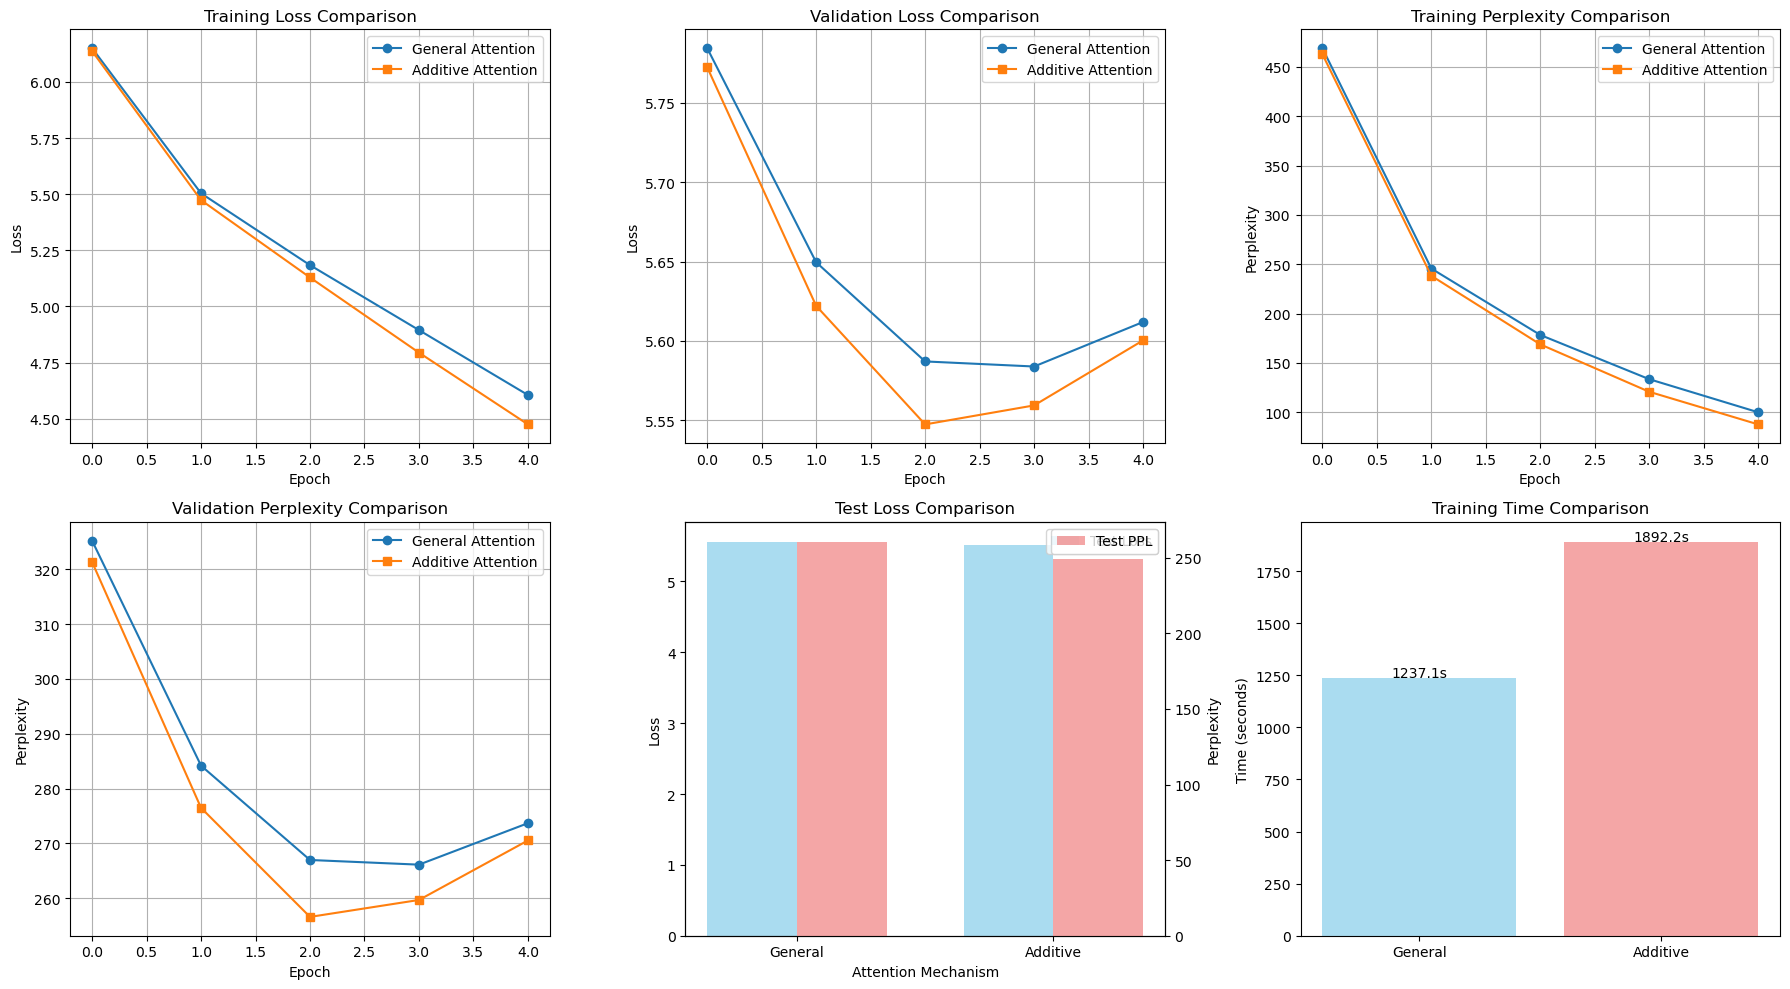


PERFORMANCE SUMMARY
Metric                    General Attention    Additive Attention  
-----------------------------------------------------------------
Final Train Loss          4.6054               4.4745              
Final Train PPL           100.0273             87.7532             
Final Val Loss            5.6119               5.6004              
Final Val PPL             273.6746             270.5232            
Test Loss                 5.5634               5.5171              
Test PPL                  260.7203             248.8999            
Training Time             1237.1              s 1892.2              s


In [28]:
def run_experiment(attention_type, model_name):
    print(f"\n{'='*60}")
    print(f"Training model with {attention_type.upper()} attention")
    print(f"{'='*60}")

    # HYPERPARAMETERS 
    EMBEDDING_DIM = 100  
    HIDDEN_DIM = 256     
    ENC_LAYERS = 1      
    DEC_LAYERS = 1      
    ENC_DROPOUT = 0.3   
    DEC_DROPOUT = 0.3    
    LEARNING_RATE = 0.001
    N_EPOCHS = 5
    CLIP = 1
    TEACHER_FORCING_RATIO = 0.5
    
    batch_size = 16  
    
    # Recreate dataloaders with smaller batch size
    train_loader_small = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader_small = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader_small = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize encoder and decoder
    encoder = Encoder(
        len(src_vocab.itos),
        EMBEDDING_DIM,
        HIDDEN_DIM,
        n_layers=ENC_LAYERS,
        dropout=ENC_DROPOUT,
        bidirectional=False,  # Use unidirectional for faster training
    )

    decoder = Decoder(
        len(tgt_vocab.itos),
        EMBEDDING_DIM,
        HIDDEN_DIM,
        n_layers=DEC_LAYERS,
        dropout=DEC_DROPOUT,
        attention_type=attention_type,
    )

    # Create model
    model = Seq2Seq(encoder, decoder, device).to(device)

    # Initialize weights
    def init_weights(m):
        for name, param in m.named_parameters():
            if "weight" in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param.data)  # Better initialization for RNNs
                else:
                    nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)

    model.apply(init_weights)

    # Count parameters
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"The model has {count_parameters(model):,} trainable parameters")

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)

    # Training loop
    train_losses = []
    val_losses = []
    train_ppl = []
    val_ppl = []
    best_val_loss = float("inf")
    start_time = time.perf_counter()

    for epoch in range(N_EPOCHS):
        epoch_start = time.perf_counter()
        
        train_loss = train(
            model, train_loader_small, optimizer, criterion, CLIP, TEACHER_FORCING_RATIO
        )
        val_loss = evaluate(model, val_loader_small, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ppl.append(math.exp(train_loss))
        val_ppl.append(math.exp(val_loss))
        
        epoch_time = time.perf_counter() - epoch_start

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pt")

        print(f"Epoch: {epoch+1:02d} | Time: {epoch_time:.1f}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
        print(f"\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}")

    total_time = time.perf_counter() - start_time
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f"{model_name}_best.pt"))
    test_loss = evaluate(model, test_loader_small, criterion)
    test_ppl = math.exp(test_loss)
    
    print(f"\nTest Loss: {test_loss:.3f} | Test PPL: {test_ppl:.3f}")
    print(f"Total Training Time: {total_time:.1f} seconds")

    return train_losses, val_losses, train_ppl, val_ppl, total_time, model, test_loss, test_ppl


# Run experiments
print("Starting experiments...")
general_results = run_experiment("general", "general_attention")
additive_results = run_experiment("additive", "additive_attention")

# Extract results
general_train_losses, general_val_losses, general_train_ppl, general_val_ppl, general_time, general_model, general_test_loss, general_test_ppl = general_results
additive_train_losses, additive_val_losses, additive_train_ppl, additive_val_ppl, additive_time, additive_model, additive_test_loss, additive_test_ppl = additive_results

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training Loss
ax1 = axes[0, 0]
ax1.plot(general_train_losses, label='General Attention', marker='o')
ax1.plot(additive_train_losses, label='Additive Attention', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True)

# Validation Loss
ax2 = axes[0, 1]
ax2.plot(general_val_losses, label='General Attention', marker='o')
ax2.plot(additive_val_losses, label='Additive Attention', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True)

# Training PPL
ax3 = axes[0, 2]
ax3.plot(general_train_ppl, label='General Attention', marker='o')
ax3.plot(additive_train_ppl, label='Additive Attention', marker='s')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Perplexity')
ax3.set_title('Training Perplexity Comparison')
ax3.legend()
ax3.grid(True)

# Validation PPL
ax4 = axes[1, 0]
ax4.plot(general_val_ppl, label='General Attention', marker='o')
ax4.plot(additive_val_ppl, label='Additive Attention', marker='s')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Perplexity')
ax4.set_title('Validation Perplexity Comparison')
ax4.legend()
ax4.grid(True)

# Test Performance Bar Chart
ax5 = axes[1, 1]
x = np.arange(2)
width = 0.35

ax5.bar(x - width/2, [general_test_loss, additive_test_loss], width, 
        label='Test Loss', color='skyblue', alpha=0.7)
ax5.set_ylabel('Loss')
ax5.set_xlabel('Attention Mechanism')
ax5.set_title('Test Loss Comparison')
ax5.set_xticks(x)
ax5.set_xticklabels(['General', 'Additive'])
ax5.legend()

ax6 = ax5.twinx()
ax6.bar(x + width/2, [general_test_ppl, additive_test_ppl], width, 
        label='Test PPL', color='lightcoral', alpha=0.7)
ax6.set_ylabel('Perplexity')
ax6.legend(loc='upper right')

# Training Time Comparison
ax7 = axes[1, 2]
ax7.bar(['General', 'Additive'], [general_time, additive_time], 
        color=['skyblue', 'lightcoral'], alpha=0.7)
ax7.set_ylabel('Time (seconds)')
ax7.set_title('Training Time Comparison')
ax7.text(0, general_time + 5, f'{general_time:.1f}s', ha='center')
ax7.text(1, additive_time + 5, f'{additive_time:.1f}s', ha='center')

plt.tight_layout()
plt.show()

# Print summary table
print(f"\n{'='*60}")
print("PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"{'Metric':<25} {'General Attention':<20} {'Additive Attention':<20}")
print(f"{'-'*65}")
print(f"{'Final Train Loss':<25} {general_train_losses[-1]:<20.4f} {additive_train_losses[-1]:<20.4f}")
print(f"{'Final Train PPL':<25} {general_train_ppl[-1]:<20.4f} {additive_train_ppl[-1]:<20.4f}")
print(f"{'Final Val Loss':<25} {general_val_losses[-1]:<20.4f} {additive_val_losses[-1]:<20.4f}")
print(f"{'Final Val PPL':<25} {general_val_ppl[-1]:<20.4f} {additive_val_ppl[-1]:<20.4f}")
print(f"{'Test Loss':<25} {general_test_loss:<20.4f} {additive_test_loss:<20.4f}")
print(f"{'Test PPL':<25} {general_test_ppl:<20.4f} {additive_test_ppl:<20.4f}")
print(f"{'Training Time':<25} {general_time:<20.1f}s {additive_time:<20.1f}s")
print(f"{'='*60}")

# Example translations
def show_example_translations(model, attention_type):
    examples = [
        "Hello, how are you?",
        "The weather is nice today.",
        "I love machine learning.",
        "What is your name?",
        "Thank you very much."
    ]
    
    print(f"\nExample Translations ({attention_type} Attention):")
    print(f"{'-'*50}")
    for i, example in enumerate(examples, 1):
        translation, _ = translate_sentence(example, model, src_vocab, tgt_vocab, device)
        print(f"{i}. Source: {example}")
        print(f"   Translation: {translation}")
        print()


In [35]:
show_example_translations(general_model, "General")


Example Translations (General Attention):
--------------------------------------------------
1. Source: Hello, how are you?
   Translation: <unk> , তুমি ?

2. Source: The weather is nice today.
   Translation: <unk> <unk> <unk> <unk>

3. Source: I love machine learning.
   Translation: আমি <unk> <unk>

4. Source: What is your name?
   Translation: তুমি কি ? ?

5. Source: Thank you very much.
   Translation: ধন্যবাদ , ধন্যবাদ.



In [36]:
show_example_translations(additive_model, "Additive")


Example Translations (Additive Attention):
--------------------------------------------------
1. Source: Hello, how are you?
   Translation: <unk> , তুমি ?

2. Source: The weather is nice today.
   Translation: <unk> <unk> <unk>

3. Source: I love machine learning.
   Translation: আমি <unk> <unk>

4. Source: What is your name?
   Translation: তুমি <unk> <unk> ?

5. Source: Thank you very much.
   Translation: ধন্যবাদ.



In [32]:
n_epoch = 5
print(f"{'Metric':<25} {'General Attention':<20} {'Additive Attention':<20}")
print(f"{'-'*65}")
print(f"{'Avg. Train Loss':<25} {sum(general_train_losses)/n_epoch:<20.4f} {sum(additive_train_losses)/n_epoch:<20.4f}")
print(f"{'Avg. Train PPL':<25} {sum(general_train_ppl)/n_epoch:<20.4f} {sum(additive_train_ppl)/n_epoch:<20.4f}")
print(f"{'Avg. Val Loss':<25} {sum(general_val_losses)/n_epoch:<20.4f} {sum(additive_val_losses)/n_epoch:<20.4f}")
print(f"{'Avg. Val PPL':<25} {sum(general_val_ppl)/n_epoch:<20.4f} {sum(additive_val_ppl)/n_epoch:<20.4f}")
print(f"{'Training Time(ms)':<25} {general_time*1000:<20.1f} {additive_time*1000:<20.1f}")
print(f"{'='*60}")

Metric                    General Attention    Additive Attention  
-----------------------------------------------------------------
Avg. Train Loss           5.2676               5.2017              
Avg. Train PPL            225.3053             215.7184            
Avg. Val Loss             5.6434               5.6203              
Avg. Val PPL              283.2296             276.9137            
Training Time(ms)         1237132.7            1892173.4           


In [34]:
print(f"{'Metric':<25} {'General Attention':<20} {'Additive Attention':<20}")
print(f"{'-'*65}")
print(f"{'Test Loss':<25} {general_test_loss:<20.4f} {additive_test_loss:<20.4f}")
print(f"{'Test PPL':<25} {general_test_ppl:<20.4f} {additive_test_ppl:<20.4f}")
print(f"{'='*60}")

Metric                    General Attention    Additive Attention  
-----------------------------------------------------------------
Test Loss                 5.5634               5.5171              
Test PPL                  260.7203             248.8999            


<h4>Traning results</h4>
<img src="rnnTrain.png" alt="train results">


<h4>Test results</h4>
<img src="rnntest.png" alt="test results">


<h4>Losses</h4>
<img src="output.png" alt="test results">


# SAVE BEST MODEL

In [37]:
def save_checkpoint(model, src_vocab, tgt_vocab, attention_type, path="seq2seq_attn.pt"):
    checkpoint = {
        "model_state_dict": model.state_dict(),

        "hparams": {
            "input_dim": len(src_vocab.itos),
            "output_dim": len(tgt_vocab.itos),
            "embedding_dim": 100,
            "hidden_dim": 256,
            "enc_layers": 1,
            "dec_layers": 1,
            "enc_dropout": 0.3,
            "dec_dropout": 0.3,
            "attention_type": attention_type,
            "bidirectional": False,
            "src_pad_idx": src_vocab.pad_idx,
            "trg_pad_idx": tgt_vocab.pad_idx,
            "max_length": 50,
        },

        "src_itos": src_vocab.get_itos(),
        "tgt_itos": tgt_vocab.get_itos(),
    }

    torch.save(checkpoint, path)
    print(f"Saved model to {path}")


In [38]:
save_checkpoint(general_model, src_vocab, tgt_vocab, 'general', "general_model.pt")
save_checkpoint(additive_model, src_vocab, tgt_vocab, 'additive', "additive_model.pt")

Saved model to general_model.pt
Saved model to additive_model.pt


In [40]:
# Load model for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("additive_model.pt", map_location=device)
h = ckpt["hparams"]

# rebuild encoder
encoder = Encoder(
    h["input_dim"],
    h["embedding_dim"],
    h["hidden_dim"],
    n_layers=h["enc_layers"],
    dropout=h["enc_dropout"],
    bidirectional=h["bidirectional"]
)

# rebuild decoder
decoder = Decoder(
    h["output_dim"],
    h["embedding_dim"],
    h["hidden_dim"],
    n_layers=h["dec_layers"],
    dropout=h["dec_dropout"],
    attention_type=h["attention_type"]
)

model = Seq2Seq(encoder, decoder, device).to(device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6555, 100, padding_idx=0)
    (rnn): GRU(100, 256, batch_first=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(8441, 100, padding_idx=0)
    (attention): AdditiveAttention(
      (W1): Linear(in_features=256, out_features=256, bias=False)
      (W2): Linear(in_features=256, out_features=256, bias=False)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(356, 256, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8441, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [41]:
# Restore vocabularies
src_vocab = Vocab()
tgt_vocab = Vocab()

src_vocab.itos = ckpt["src_itos"]
tgt_vocab.itos = ckpt["tgt_itos"]

src_vocab.stoi = {w: i for i, w in enumerate(src_vocab.itos)}
tgt_vocab.stoi = {w: i for i, w in enumerate(tgt_vocab.itos)}

for v in (src_vocab, tgt_vocab):
    v.pad_idx = v.stoi["<pad>"]
    v.sos_idx = v.stoi["<sos>"]
    v.eos_idx = v.stoi["<eos>"]
    v.unk_idx = v.stoi["<unk>"]

In [47]:
translation, attention = translate_sentence(
    "they are good!",
    model,
    src_vocab,
    tgt_vocab,
    device,
    max_len=h["max_length"]
)

print("BN:", translation)


BN: তারা <unk> !
